# Ants in Space! An introduction to the code in [beam_paco__gtoc5](https://github.com/lfsimoes/beam_paco__gtoc5)


Luís F. Simões

2017-04

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

---

In [1]:
# https://esa.github.io/pykep/
# https://github.com/esa/pykep
# https://pypi.python.org/pypi/pykep/
import PyKEP as pk

In [2]:
import numpy as np

In [3]:
from tqdm import tqdm, trange

In [4]:
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
plt.rcParams['figure.figsize'] = 10, 8

In [5]:
from gtoc5 import *
from gtoc5.multiobjective import *
from gtoc5.phasing import *

In [6]:
from paco import *

In [7]:
from paco_traj import *
from experiments import *
from experiments__paco import *

---

Taking a look at our Python environment.

In [8]:
%load_ext watermark
%watermark -v -m -p PyKEP,numpy,scipy,tqdm,pandas,matplotlib,seaborn
# https://github.com/rasbt/watermark

CPython 3.5.3
IPython 5.3.0

PyKEP {'major': 1, 'minor': 3, 'bugfix': 9}
numpy 1.12.1
scipy 0.19.0
tqdm 4.11.2
pandas 0.19.2
matplotlib 2.0.0
seaborn 0.7.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


---

# Solving a TSPLIB problem with P-ACO

In this section we show the steps to solve a Travelling Salesman Problem (TSP) instance with the Population-based Ant Colony Optimization (P-ACO) algorithm.

We'll use a TSP instance downloaded from the [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/): `eil101` (symmetric, 101 cities, total distance in best known solution: [629](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html)).

In [9]:
from urllib.request import urlretrieve
import gzip

In [10]:
urlretrieve('http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/eil101.tsp.gz', filename='eil101.tsp.gz');

Load each city's (x, y) coordinates.

In [11]:
with gzip.open('eil101.tsp.gz') as f:
    xy_locs = np.loadtxt(f, skiprows=6, usecols=(1,2), comments='EOF', dtype=np.int)
nr_cities = len(xy_locs)
xy_locs[:5]

array([[41, 49],
       [35, 17],
       [55, 45],
       [55, 20],
       [15, 30]])

Calculate distances matrix.

In [12]:
distances = np.zeros((nr_cities, nr_cities))
for a in range(nr_cities):
    for b in range(a, nr_cities):
        distances[a,b] = distances[b,a] = np.linalg.norm(xy_locs[a] - xy_locs[b])

distances[:4, :4]

array([[  0.        ,  32.55764119,  14.56021978,  32.20248438],
       [ 32.55764119,   0.        ,  34.40930107,  20.22374842],
       [ 14.56021978,  34.40930107,   0.        ,  25.        ],
       [ 32.20248438,  20.22374842,  25.        ,   0.        ]])

Instantiate the TSP "path handler" with this distances matrix, and P-ACO, with its default parameters.

In [13]:
rng, seed = initialize_rng(seed=None)
print('Seed:', seed)

Seed: 2608067369


In [14]:
path_handler = tsp_path(distances, random_state=rng)
aco = paco(path_handler.nr_nodes, path_handler, random_state=rng)

Solve it.

In [15]:
%time (quality, best) = aco.solve(nr_generations=100)
quality

Wall time: 6.88 s


672.14610316279925

Continue refining the solution for a few more generations.

In [16]:
%time (quality, best) = aco.solve(nr_generations=400, reinitialize=False)
quality

Wall time: 27.2 s


647.17563526781532

Let's see what we found.

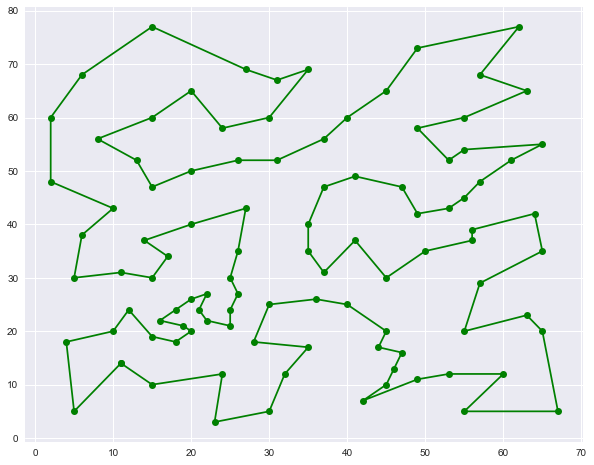

In [17]:
xy = np.vstack([xy_locs[best], xy_locs[best][0]]) # to connect back to the start
line, = plt.plot(xy[:,0], xy[:,1], 'go-')

---

# Basic steps for assembling GTOC5 trajectories

The two primary functions for assembling a GTOC5 trajectory are here `mission_to_1st_asteroid()` and `add_asteroid()`. The first initializes the mission's data structure with the details of the Earth launch leg, that takes the spacecraft towards the mission's first asteroid. Subsequently, via multiple calls to `add_asteroid()`, the mission is extended with additional exploration targets. Each call to `add_asteroid()` creates a rendezvous leg towards the specified asteroid, immediately followed by a flyby of that same asteroid, and so increases the mission's overall score by 1.

Here's an example of a mission that launches towards asteroid `1712`, and moves next to asteroid `4893`. The `True` value returned by `add_asteroid()` indicates that a feasible transfer leg was found, and asteroid `4893` was therefore added to the mission.

In [18]:
t = mission_to_1st_asteroid(1712)

In [19]:
add_asteroid(t, 4893)

True

We can evaluate this trajectory with respect to its score (number of asteroids fully explored), final mass (in kg), and time of flight (here converted from days to years).

In [20]:
score(t), final_mass(t), tof(t) * DAY2YEAR

(2.0, 3484.7515275785117, 1.6150747703446979)

An aggregation of the mission's mass and time costs can be obtained with `resource_rating()`. It measures the extent to which the mass and time budgets available for the mission have been depleted by the trajectory. It produces a value of 1.0 at the start of the mission, and a value of 0.0 when the mission has exhausted its 3500 kg of available mass, or its maximum duration of 15 years.

In [21]:
resource_rating(t)

0.8721092603416899

As the score increments discretely by 1.0 with each added asteroid, and the resource rating evaluates mass and time available in a range of [0, 1], both can be combined to give a single-objective evaluation of the trajectory, that should be maximized:

In [22]:
score(t) + resource_rating(t)

2.87210926034169

Calling `seq()`, we can see either the full sequence of asteroids visited in each leg, or just the distinct asteroids visited in the mission. In this example, we see that the mission starts on Earth (id `0`), performs a rendezvous with asteroid `1712`, followed by a flyby of the same asteroid, and then repeats the pattern at asteroid `4893`.

In [23]:
print(seq(t))
print(seq(t, incl_flyby=False))

[0, 1712, 1712, 4893, 4893]
[0, 1712, 4893]


The trajectory data structure built by `mission_to_1st_asteroid()` and `add_asteroid()` is a list of tuples summarizing the evolution of the spacecraft's state. It provides the minimal sufficient information from which a more detailed view can be reproduced, if so desired. Each tuple contains:

1. asteroid ID
2. spacecraft mass
3. [epoch][epoch]
4. the leg's $\Delta T$
5. the leg's $\Delta V$

The mass and epoch values correspond to the state at the given asteroid, at the end of a rendezvous or self-fly-by leg, after deploying the corresponding payload. The $\Delta T$ and $\Delta V$ values refer to that leg that just ended.

[epoch]: https://en.wikipedia.org/wiki/Epoch_(astronomy)

In [24]:
t[-1]

(4893,
 3484.7515275785117,
 59717.111314916867,
 134.19998321371767,
 965.6854249492379)

Epochs are given here as [Modified Julian Dates (MJD)](https://en.wikipedia.org/wiki/Julian_day#Variants), and can be converted as:

In [25]:
pk.epoch(t[-1][2], 'mjd')

2022-May-18 02:40:17.608817

## Greedy search

In this section we perform a [Greedy search](https://en.wikipedia.org/wiki/Greedy_algorithm) for a GTOC5 trajectory. We'll start by going to asteroid `1712`. Then, and at every following step, we attempt to create legs towards all still available asteroids. Among equally-scored alternatives, we greedily pick the one with highest resource rating to adopt into the trajectory, and continue from there. Search stops when no feasible legs are found that can take us to another asteroid. This will happen either because no solutions were found that would allow for a leg to be created, or because adding a found solution would require the spacecraft to exceed the mission's mass or time budgets.

In [26]:
import os
from copy import copy

In [27]:
def greedy_step(traj):
    traj_asts = set(seq(traj, incl_flyby=False))
    progress_bar_args = dict(leave=False, file=os.sys.stdout, desc='attempting score %d' % (score(traj)+1))
    
    extended = []
    for a in trange(len(asteroids), **progress_bar_args):
        if a in traj_asts:
            continue
        tt = copy(traj)
        if add_asteroid(tt, next_ast=a, use_cache=False):
            extended.append(tt)
    
    return max(extended, key=resource_rating, default=[])

In [28]:
# measure time taken at one level to attempt legs towards all asteroids (that aren't already in the traj.)
%time _ = greedy_step(mission_to_1st_asteroid(1712))

Wall time: 11 s                                                                                                             


In [29]:
def greedy_search(first_ast):
    t = mission_to_1st_asteroid(first_ast)
    while True:
        tt = greedy_step(t)
        if tt == []:
            # no more asteroids could be added
            return t
        t = tt

In [30]:
%time T = greedy_search(first_ast=1712)

Wall time: 2min 30s                                                                                                         


In [31]:
score(T), resource_rating(T), final_mass(T), tof(T) * DAY2YEAR

(14.0, 0.041241978351621127, 584.8278465118636, 12.926528012051794)

In [32]:
print(seq(T, incl_flyby=False))

[0, 1712, 4893, 4028, 6939, 1059, 3295, 4006, 4981, 6437, 5344, 2090, 3993, 4186, 1130]


Greedy search gave us a trajectory that is able to visit 14 distinct asteroids. However, by the 14th, the spacecraft finds itself unable to find a viable target to fly to next, even though it has 84.8 kg of mass still available (the spacecraft itself weighs 500 kg, so the mission cannot go below that value), and 2 years remain in its 15 year mission.

## Phasing indicators

A big disadvantage of the approach followed above is the high computational cost of deciding which asteroid to go to next. It entails the optimization of up to 7075 legs, only to then pick a single one and discard all the other results.

An alternative is to use one of the indicators available in `gtoc5/phasing.py`. They can provide an indication of how likely a specific asteroid is to be an easily reachable target.

In [33]:
t = mission_to_1st_asteroid(1712)

We use here the (improved) orbital phasing indicator to rate destinations with respect to the estimated ΔV of hypothetical legs that would depart from `dep_ast`, at epoch `dep_t`, towards each possible asteroid, arriving there within `leg_dT` days. We don't know exactly how long the transfer time chosen by `add_asteroid()` would be, but we take `leg_dT=125` days as reference transfer time.

In [34]:
r = rate__orbital_2(dep_ast=t[-1][0], dep_t=t[-1][2], leg_dT=125)
r[seq(t)] = np.inf  # (exclude bodies already visited)

Below are the 5 asteroids the indicator estimates would be most easily reachable. As we've seen above in the results from the greedy search, asteroid `4893`, here the 2nd best rated alternative, would indeed be the target reachable with lowest ΔV.

In [35]:
r.argsort()[:5]

array([1679, 4893, 1528, 5331, 1663], dtype=int64)

The indicator is however not infallible. If we attempt to go from asteroid `1712` towards each of these asteroids, we find that none of them are actually reachable, except for `4893`! Still, the indicator allows us to narrow our focus considerably.

In [36]:
[add_asteroid(copy(t), a) for a in r.argsort()[:5]]

[False, True, False, False, False]

Armed with the indicator, we can reimplement the greedy search, so it will only optimize legs towards a number of top rated alternatives, and then proceed with the best out of those.

In [37]:
def narrowed_greedy_step(traj, top=10):
    traj_asts = set(seq(traj, incl_flyby=False))
    
    extended = []
    ratings = rate__orbital_2(dep_ast=traj[-1][0], dep_t=traj[-1][2], leg_dT=125)
    for a in ratings.argsort()[:top]:
        if a in traj_asts:
            continue
        tt = copy(traj)
        if add_asteroid(tt, next_ast=a, use_cache=False):
            extended.append(tt)
    
    return max(extended, key=resource_rating, default=[])

In [38]:
def narrowed_greedy_search(first_ast, **kwargs):
    t = mission_to_1st_asteroid(first_ast)
    while True:
        tt = narrowed_greedy_step(t, **kwargs)
        if tt == []:
            # no more asteroids could be added
            return t
        t = tt

In [39]:
# measure time taken at one level to attempt legs towards the best `top` asteroids
%time _ = narrowed_greedy_step(mission_to_1st_asteroid(1712), top=10)

Wall time: 105 ms


In [40]:
%time T = narrowed_greedy_search(first_ast=1712, top=10)

Wall time: 1.29 s


In [41]:
score(T), resource_rating(T), final_mass(T), tof(T) * DAY2YEAR

(14.0, 0.020976850009091538, 542.5005372055895, 13.845381094048889)

In [42]:
print(seq(T, incl_flyby=False))

[0, 1712, 4893, 4028, 6939, 1059, 505, 6060, 3907, 5051, 2413, 6819, 913, 6638, 6723]


We were able to find another score 14 trajectory, but this time it took us ~1 second, whereas before it was taking us 2 and a half minutes.

---

# Finding a GTOC5 trajectory of score 17 with Beam Search

In [17]:
gtoc_ph = init__path_handler(multiobj_evals=True)

In [18]:
# configuring Beam P-ACO to behave as a deterministic multi-objective Beam Search
_args = {
    'beam_width': 20,
    'branch_factor': 250,
    'alpha': 0.0,        # 0.0: no pheromones used
    'beta': 1.0,
    'prob_greedy': 1.0,  # 1.0: deterministic, greedy branching decisions
    }

In [19]:
bpaco = beam_paco_pareto(nr_nodes=len(asteroids), path_handler=gtoc_ph, random_state=None, **_args)

In [20]:
# start the search
# given we're running the algoritm in deterministic mode, we execute it for a single generation
%time best_pf = bpaco.solve(nr_generations=1)

Wall time: 2min 10s


In [21]:
# being this a `_pareto` class, .best returns a Pareto front
# pick the first solution from the Pareto front
best_eval, best = best_pf[0]

In [22]:
# Evaluation of the best found solution
# (score, mass consumed, time of flight)
best_eval

(17.0, 3496.8299418637093, 14.824982263414686)

In [25]:
# sequence of asteroids visited (0 is the Earth)
print(seq(best, incl_flyby=False))

[0, 1712, 4893, 2579, 6979, 5469, 6740, 2445, 6301, 5174, 5884, 4165, 4028, 6240, 3988, 1779, 6813, 3243]


In [24]:
# mission data structure, up to the full scoring of the first two asteroids
best[:5]

[(0, 4000.0, 59127.205255048466, 0.0, 0.0),
 (1712,
  3872.530999146394,
  59181.08381655966,
  53.87856151119195,
  650.4716282561097),
 (1712,
  3746.481928641157,
  59325.360311294986,
  144.27649473533114,
  965.6854249492379),
 (4893,
  3602.066962005158,
  59582.911331703152,
  257.55102040816325,
  831.5807789590044),
 (4893,
  3484.7515275785117,
  59717.111314916867,
  134.19998321371767,
  965.6854249492379)]

---

Generate the Table of Contents

In [43]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies

<IPython.core.display.Javascript object>